In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Load Dataset

In [2]:
df = pd.read_csv("final_dataset4.csv")
df.head()

,log_ratio_to_median_purchase_price,log_distance_from_home,log_distance_last_transaction,online_order,fraud
0,1.217638,4.561108,0.192351,0,0
1,0.624628,1.146797,1.532829,1,0
2,0.450213,2.219368,0.179645,1,0
3,0.559312,1.034320,0.478460,1,0
4,0.959727,3.303655,1.770133,1,0


In [3]:
X = df.drop(columns=["fraud"])
y = df["fraud"]

print("Features:", X.shape)
print("Labels distribution:\n", y.value_counts())


Features: (100000, 4)
Labels distribution:
 fraud
0    91260
1     8740
Name: count, dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [5]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [6]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [7]:
idx_0 = np.where(y_train == 0)[0]
idx_1 = np.where(y_train == 1)[0]

N = min(len(idx_1), 100)

idx_balanced = np.concatenate([
    idx_0[:N],
    idx_1[:N]
])

X_train_small = X_train[idx_balanced]
y_train_small = y_train[idx_balanced]

print(np.bincount(y_train_small))

[100 100]


In [8]:
scaler = StandardScaler()

X_train_small = scaler.fit_transform(X_train_small)
X_test = scaler.transform(X_test)

# Classical models

Logistic regression

In [9]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)
lr.fit(X_train_small, y_train_small)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [10]:
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_proba_lr)

print("Logistic Regression Accuracy:", lr_acc)
print("Logistic Regression AUC:", lr_auc)


Logistic Regression Accuracy: 0.86045
Logistic Regression AUC: 0.9408714057103426


Random Forest 

In [11]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train_small, y_train_small)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
y_pred_qml = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred_qml)
auc = roc_auc_score(y_test, y_pred_qml)

print("Accuracy:", acc)
print("AUC:", auc)

Accuracy: 0.95425
AUC: 0.9604500256014075


# QML

In [13]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.utils import algorithm_globals

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer import AerSimulator
from qiskit import transpile


In [14]:
algorithm_globals.random_seed = 42
n_features = X_train.shape[1]

print("Number of qubits:", n_features)

Number of qubits: 4


In [15]:
feature_map = ZZFeatureMap(
    feature_dimension=n_features,
    reps=2,
    entanglement="full"
)
feature_map

C:\Users\dell\AppData\Local\Temp\ipykernel_22072\2642578032.py:1: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(


In [16]:
ansatz = RealAmplitudes(
    num_qubits=n_features,
    reps=2,
    entanglement="full"
)
ansatz

C:\Users\dell\AppData\Local\Temp\ipykernel_22072\3592231173.py:1: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(


In [17]:
n_qubits = n_features
n_layers = 2

theta = ParameterVector("θ", 2 * n_features * n_layers)

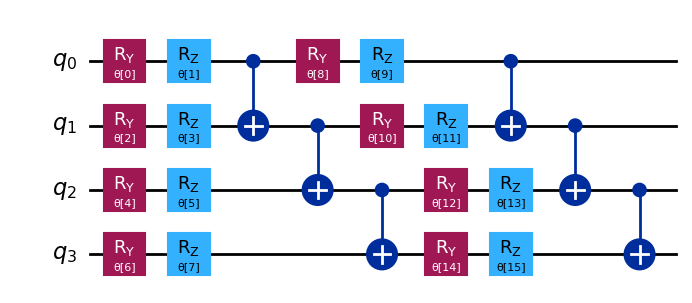

In [18]:
qc = QuantumCircuit(n_qubits)

param_index = 0
for layer in range(n_layers):

    # Rotation layer
    for q in range(n_qubits):
        qc.ry(theta[param_index], q)
        qc.rz(theta[param_index + 1], q)
        param_index += 2

    # Entanglement layer (linear chain)
    for q in range(n_qubits - 1):
        qc.cx(q, q + 1)

qc.draw("mpl")


In [19]:
y_train = np.array(y_train)
y_test = np.array(y_test)

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=30)
)

vqc.fit(X_train_small, y_train_small)



No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [20]:
y_pred_qml = vqc.predict(X_test)

qml_acc = accuracy_score(y_test, y_pred_qml)
qml_auc = roc_auc_score(y_test, y_pred_qml)

print("QML Accuracy:", qml_acc)
print("QML AUC:", qml_auc)

QML Accuracy: 0.49775
QML AUC: 0.509889076448661


Noise simulation

In [ ]:
trained_weights = vqc._fit_result.x
feature_params = vqc.neural_network.input_params
weight_params = vqc.neural_network.weight_params

In [22]:
noise_model = NoiseModel()

# Gate error probabilities
error_1q = depolarizing_error(0.01, 1)   # 1-qubit gates
error_2q = depolarizing_error(0.05, 2)   # 2-qubit gates

noise_model.add_all_qubit_quantum_error(error_1q, ['ry', 'rz'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

noisy_backend = AerSimulator(noise_model=noise_model)

In [ ]:
def get_prob_class1(counts):
    shots = sum(counts.values())
    prob = 0.0
    for bitstring, c in counts.items():
        if bitstring[-1] == '1': 
            prob += c / shots
    return prob

In [ ]:
y_score_noisy = []
y_true = []

for i in range(30):   
    x = X_test[i]

    param_dict = {}
    for p, v in zip(feature_params, x):
        param_dict[p] = v
    for p, v in zip(weight_params, trained_weights):
        param_dict[p] = v

    qc = vqc.neural_network.circuit.assign_parameters(param_dict)
    qc.measure_all()

    tqc = transpile(qc, noisy_backend)
    result = noisy_backend.run(tqc, shots=1024).result()
    counts = result.get_counts()

    y_score_noisy.append(get_prob_class1(counts))
    y_true.append(y_test[i])

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score

y_score_noisy = np.array(y_score_noisy)
y_true = np.array(y_true)

y_pred_noisy = (y_score_noisy > 0.5).astype(int)

noisy_acc = accuracy_score(y_true, y_pred_noisy)
noisy_auc = roc_auc_score(y_true, y_score_noisy)

print("Noisy VQC Accuracy:", noisy_acc)
print("Noisy VQC AUC:", noisy_auc)

Noisy VQC Accuracy: 0.4
Noisy VQC AUC: 0.3839285714285714


# QNN

In [26]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA

In [27]:
n_qubits = X_train_small.shape[1]

feature_map = ZZFeatureMap(n_qubits, reps=2)
ansatz = RealAmplitudes(n_qubits, reps=2)

qc = QuantumCircuit(n_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

C:\Users\dell\AppData\Local\Temp\ipykernel_22072\2197114516.py:3: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(n_qubits, reps=2)
C:\Users\dell\AppData\Local\Temp\ipykernel_22072\2197114516.py:4: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(n_qubits, reps=2)


In [28]:
qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [29]:
qnn_classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=COBYLA(maxiter=30)
)

qnn_classifier.fit(X_train_small, y_train_small)

In [30]:
# Predictions
qnn_preds = qnn_classifier.predict(X_test)
qnn_probs = qnn_classifier.predict_proba(X_test)
qnn_scores = qnn_probs.ravel() 

# Metrics
print("QNN Accuracy:", accuracy_score(y_test, qnn_preds))
print("QNN AUC:", roc_auc_score(y_test, qnn_scores))

QNN Accuracy: 0.05535
QNN AUC: 0.5405185212767505


In [31]:
qc = QuantumCircuit(n_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

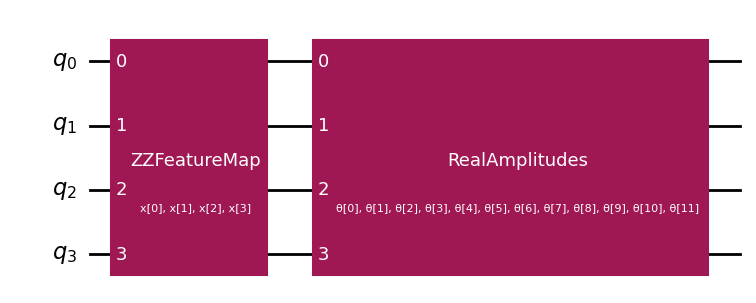

In [32]:
qc.draw("mpl")